# Exploracion del Dataset: Old Book Illustrations

Analizamos el dataset `gigant/oldbookillustrations` para entender su estructura
y definir las transformaciones necesarias para el fine-tuning de Stable Diffusion.

In [2]:
from datasets import load_dataset
from torchvision import transforms
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import numpy as np

# Permitir imagenes truncadas del dataset
ImageFile.LOAD_TRUNCATED_IMAGES = True

## 1. Cargar dataset y ver columnas disponibles

In [3]:
dataset_name = "gigant/oldbookillustrations"
dataset = load_dataset(dataset_name, split="train")

print(f"Numero de muestras: {len(dataset)}")
print(f"Columnas: {dataset.column_names}")
print(f"\nEjemplo de una fila:")
print(dataset[0])

Numero de muestras: 4154
Columnas: ['rawscan', '1600px', 'info_url', 'info_src', 'info_alt', 'artist_name', 'artist_birth_date', 'artist_death_date', 'artist_countries', 'book_title', 'book_authors', 'book_publishers', 'date_published', 'openlibrary-url', 'tags', 'illustration_source_name', 'illustration_source_url', 'illustration_subject', 'illustration_format', 'engravers', 'image_title', 'image_caption', 'image_description', 'rawscan_url', '1600px_url']

Ejemplo de una fila:
{'rawscan': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2281x3253 at 0x1542DE95410>, '1600px': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1158x1600 at 0x1542DE41650>, 'info_url': 'https://www.oldbookillustrations.com/illustrations/making-friends/', 'info_src': 'https://www.oldbookillustrations.com/wp-content/uploads/2022/08/making-friends-220x220.jpg', 'info_alt': 'A bald man with a long beard smiles faintly as he carries on his back a little girl wearing his hat', 'artist_name': 'Boughton

## 2. Analizar tamaños de imagenes

**OJO:** A diferencia del dataset Pokemon,
las ilustraciones de libros antiguos tienen proporciones variadas. 

In [4]:
# Recopilar tamanos de todas las imagenes
widths = []
heights = []
aspect_ratios = []

for i in range(len(dataset)):
    img = dataset[i]["1600px"]
    w, h = img.size
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(w / h)

print(f"Ancho  - min: {min(widths)}, max: {max(widths)}, media: {np.mean(widths):.0f}")
print(f"Alto   - min: {min(heights)}, max: {max(heights)}, media: {np.mean(heights):.0f}")
print(f"Aspect ratio - min: {min(aspect_ratios):.2f}, max: {max(aspect_ratios):.2f}, media: {np.mean(aspect_ratios):.2f}")

# Cuantas son cuadradas?
cuadradas = sum(1 for w, h in zip(widths, heights) if w == h)
print(f"\nImagenes cuadradas: {cuadradas}/{len(dataset)} ({100*cuadradas/len(dataset):.1f}%)")

Ancho  - min: 463, max: 2084, media: 1310
Alto   - min: 333, max: 2912, media: 1472
Aspect ratio - min: 0.29, max: 3.43, media: 0.94

Imagenes cuadradas: 86/4154 (2.1%)


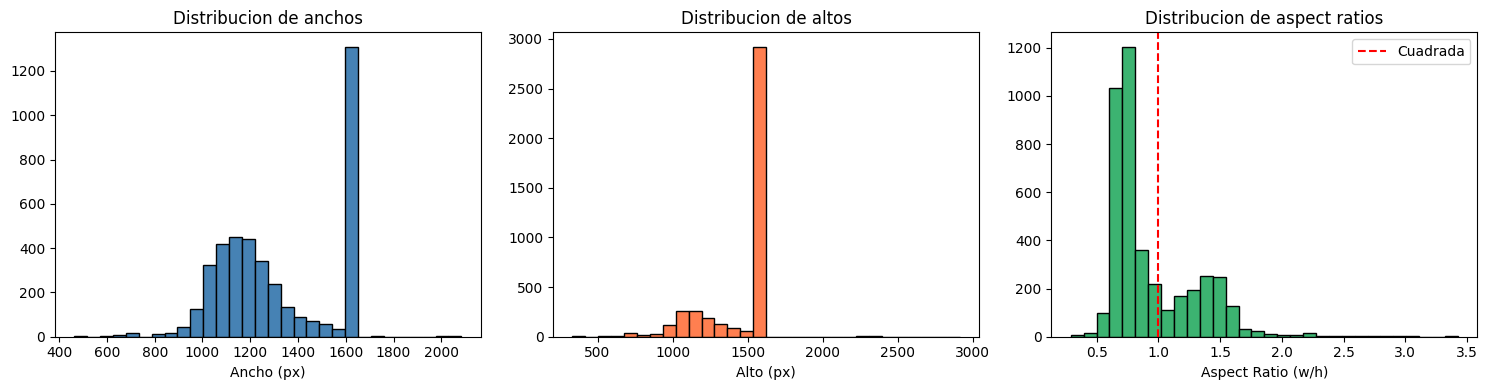

In [5]:
# Histogramas de tamanos
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(widths, bins=30, color='steelblue', edgecolor='black')
axes[0].set_title('Distribucion de anchos')
axes[0].set_xlabel('Ancho (px)')

axes[1].hist(heights, bins=30, color='coral', edgecolor='black')
axes[1].set_title('Distribucion de altos')
axes[1].set_xlabel('Alto (px)')

axes[2].hist(aspect_ratios, bins=30, color='mediumseagreen', edgecolor='black')
axes[2].set_title('Distribucion de aspect ratios')
axes[2].set_xlabel('Aspect Ratio (w/h)')
axes[2].axvline(x=1.0, color='red', linestyle='--', label='Cuadrada')
axes[2].legend()

plt.tight_layout()
plt.show()

## 3. Visualizar muestras con sus captions

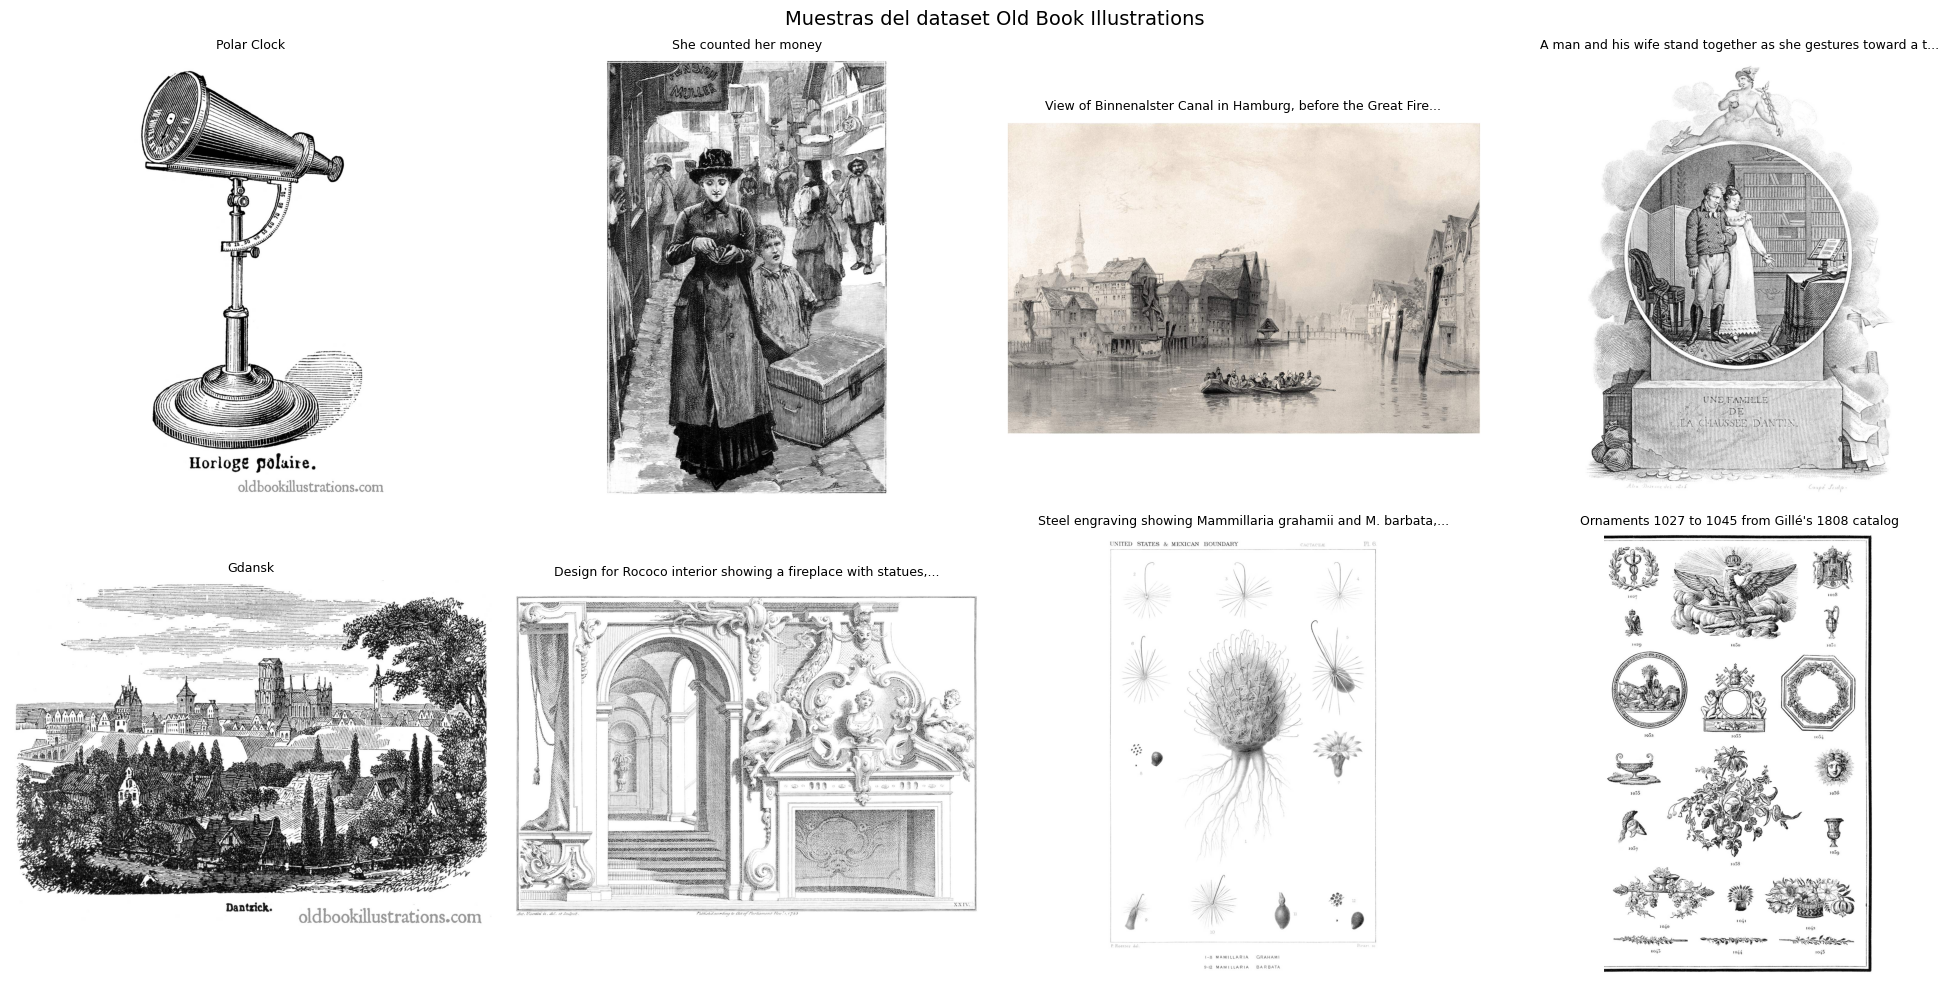

In [6]:
# Mostrar 8 muestras del dataset
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
indices = np.random.choice(len(dataset), 8, replace=False)

for ax, idx in zip(axes.flat, indices):
    example = dataset[int(idx)]
    img = example["1600px"]
    caption = example["info_alt"]
    ax.imshow(img)
    ax.set_title(caption[:60] + "..." if len(caption) > 60 else caption, fontsize=9)
    ax.axis('off')

plt.suptitle('Muestras del dataset Old Book Illustrations', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Comparar transformaciones

Comparamos dos estrategias de resize:
- **Resize(512, 512):** Estira la imagen.
- **Resize(512) + CenterCrop(512):** redimensionar el lado menor a 512, luego recortar el centro. Preservar proporciones.


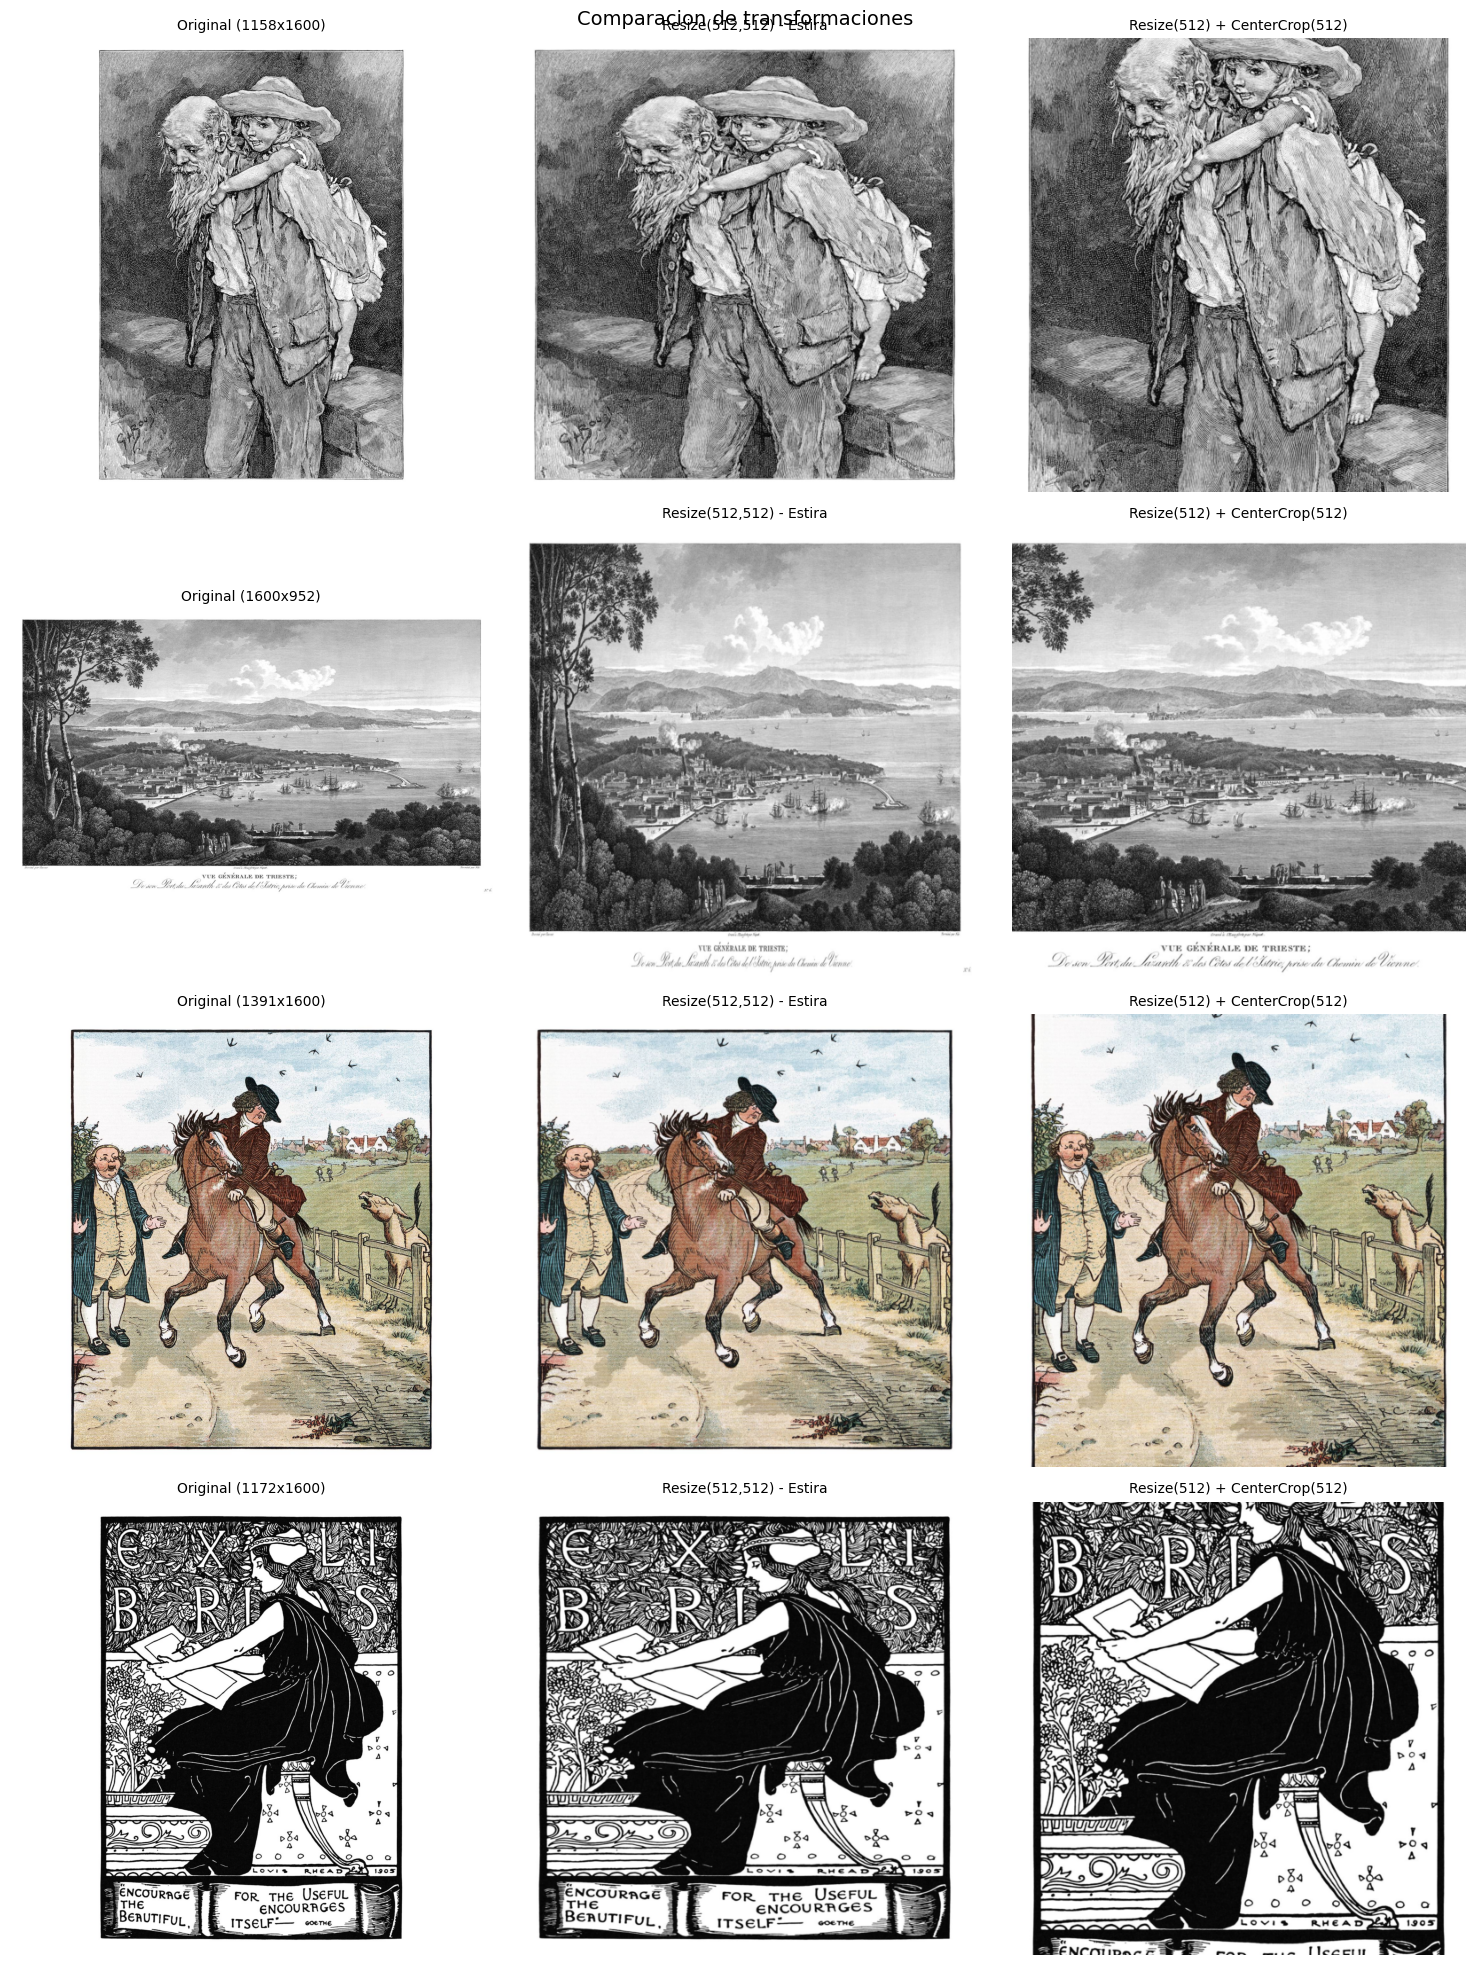

In [7]:
# Definir las dos transformaciones
transform_stretch = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

transform_crop = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
])

# Comparar con 4 imagenes del dataset
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

sample_indices = [0, 10, 50, 100]
for row, idx in enumerate(sample_indices):
    img = dataset[idx]["1600px"].convert("RGB")
    w, h = img.size
    
    stretched = transforms.ToPILImage()(transform_stretch(img))
    cropped = transforms.ToPILImage()(transform_crop(img))
    
    axes[row, 0].imshow(img)
    axes[row, 0].set_title(f'Original ({w}x{h})', fontsize=10)
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(stretched)
    axes[row, 1].set_title('Resize(512,512) - Estira', fontsize=10)
    axes[row, 1].axis('off')
    
    axes[row, 2].imshow(cropped)
    axes[row, 2].set_title('Resize(512) + CenterCrop(512)', fontsize=10)
    axes[row, 2].axis('off')

plt.suptitle('Comparacion de transformaciones', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Verificar integridad del dataset

Comprobamos que no hay imagenes rotas ni captions vacias.

In [8]:
# Verificar integridad
resolution = 512
image_transforms = transforms.Compose([
    transforms.Resize(resolution),
    transforms.CenterCrop(resolution),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

errores = 0
captions_vacios = 0

for i in range(len(dataset)):
    example = dataset[i]
    
    # Verificar caption
    caption = example["info_alt"]
    if not caption or caption.strip() == "":
        captions_vacios += 1
    
    # Verificar imagen
    try:
        img = example["1600px"].convert("RGB")
        tensor = image_transforms(img)
        assert tensor.shape == (3, 512, 512)
    except Exception as e:
        print(f"Error en muestra {i}: {e}")
        errores += 1

print(f"\nResultados de verificacion:")
print(f"  Total muestras: {len(dataset)}")
print(f"  Imagenes con error: {errores}")
print(f"  Captions vacios: {captions_vacios}")
print(f"  Todas las imagenes se procesan correctamente: {errores == 0}")


Resultados de verificacion:
  Total muestras: 4154
  Imagenes con error: 0
  Captions vacios: 0
  Todas las imagenes se procesan correctamente: True


## Conclusiones

1. Las imagenes del dataset **no son cuadradas** (a diferencia del dataset Pokemon).
2. `Resize(512) + CenterCrop(512)` en vez de `Resize((512, 512))` para no distorsionar.
3. La columna de imagen es `"1600px"` (en vez de `"image"` del Pokemon).
4. La columna de caption es `"info_alt"` (en vez de `"text"` del Pokemon).